# Overnight returns

[Overnight Returns and Firm-Specific Investor Sentiment](https://papers.ssrn.com/sol3/papers.cfm?abstract_id=2554010)

> **Abtract**: We explore the possibility that overnight returns can serve as a measure of firm-specific investor sentiment by analyzing whether they exhibit characteristics expected of a sentiment measure. First, we document short-term persistence in overnight returns, consistent with existing evidence of short-term persistence in share demand of sentiment-influenced retail investors. Second, we find that short-term persistence is stronger for harder-to-value firms, consistent with evidence that sentiment plays a larger role when there is less objective data available for valuation. Third, we show that stocks with high (low) overnight returns underperform (outperform) over the longer-term, consistent with evidence of temporary sentiment-driven mispricing.  

> **p 2, I**: The recent work of Berkman, Koch, Tuttle, and Zhang (2012) suggests that a stock’s
overnight (close-to-open) return can serve as a measure of firm-level sentiment.

> **p 3, I**: Specifically, Berkman et al. (2012) find that attention-generating events (high absolute returns or
strong net buying by retail investors) on one day lead to higher demand by individual investors,
concentrated near the open of the next trading day...This creates temporary price pressure at the
open, resulting in elevated overnight returns that are reversed during the trading day.

> **p 3, I**: We conduct three sets of analyses. **In the first
we test for short-run persistence in overnight returns.** The basis for expecting this from a
measure of sentiment is the evidence in Barber et al. (2009) that the order imbalances of retail
investors, who are the investors most likely to exhibit sentiment, persist for periods extending
over several weeks...In the third analysis we
examine whether stocks with high overnight returns underperform those with low overnight
returns over the long term.

## Install packages

In [1]:
import sys

In [2]:
!{sys.executable} -m pip install -r requirements.txt

    100% |████████████████████████████████| 18.9MB 1.5MB/s eta 0:00:01
    100% |████████████████████████████████| 880kB 8.8MB/s eta 0:00:01
    100% |████████████████████████████████| 12.2MB 2.3MB/s eta 0:00:01   41% |█████████████▎                  | 5.0MB 26.5MB/s eta 0:00:01    63% |████████████████████▍           | 7.7MB 28.8MB/s eta 0:00:01    74% |████████████████████████        | 9.1MB 29.8MB/s eta 0:00:01    86% |███████████████████████████▋    | 10.5MB 29.9MB/s eta 0:00:01
    100% |████████████████████████████████| 7.3MB 5.7MB/s eta 0:00:01    63% |████████████████████▎           | 4.6MB 30.0MB/s eta 0:00:01
    100% |████████████████████████████████| 1.1MB 13.7MB/s ta 0:00:01
    100% |████████████████████████████████| 50.0MB 706kB/s eta 0:00:01  8% |██▋                             | 4.0MB 26.1MB/s eta 0:00:02    10% |███▍                            | 5.3MB 24.8MB/s eta 0:00:02    15% |████▉                           | 7.5MB 23.4MB/s eta 0:00:02    17% |█████▌              

In [3]:
import cvxpy as cvx
import numpy as np
import pandas as pd
import time
import os
import quiz_helper
import matplotlib.pyplot as plt

In [4]:
%matplotlib inline
plt.style.use('ggplot')
plt.rcParams['figure.figsize'] = (14, 8)

### data bundle

In [5]:
import os
import quiz_helper
from zipline.data import bundles

In [6]:
os.environ['ZIPLINE_ROOT'] = os.path.join(os.getcwd(), '..', '..','data','module_4_quizzes_eod')
ingest_func = bundles.csvdir.csvdir_equities(['daily'], quiz_helper.EOD_BUNDLE_NAME)
bundles.register(quiz_helper.EOD_BUNDLE_NAME, ingest_func)
print('Data Registered')

Data Registered


### Build pipeline engine

In [7]:
from zipline.pipeline import Pipeline
from zipline.pipeline.factors import AverageDollarVolume
from zipline.utils.calendars import get_calendar

universe = AverageDollarVolume(window_length=120).top(500) 
trading_calendar = get_calendar('NYSE') 
bundle_data = bundles.load(quiz_helper.EOD_BUNDLE_NAME)
engine = quiz_helper.build_pipeline_engine(bundle_data, trading_calendar)

### View Data¶
With the pipeline engine built, let's get the stocks at the end of the period in the universe we're using. We'll use these tickers to generate the returns data for the our risk model.

In [8]:
universe_end_date = pd.Timestamp('2016-01-05', tz='UTC')

universe_tickers = engine\
    .run_pipeline(
        Pipeline(screen=universe),
        universe_end_date,
        universe_end_date)\
    .index.get_level_values(1)\
    .values.tolist()
    
universe_tickers

[Equity(0 [A]),
 Equity(1 [AAL]),
 Equity(2 [AAP]),
 Equity(3 [AAPL]),
 Equity(4 [ABBV]),
 Equity(5 [ABC]),
 Equity(6 [ABT]),
 Equity(7 [ACN]),
 Equity(8 [ADBE]),
 Equity(9 [ADI]),
 Equity(10 [ADM]),
 Equity(11 [ADP]),
 Equity(12 [ADS]),
 Equity(13 [ADSK]),
 Equity(14 [AEE]),
 Equity(15 [AEP]),
 Equity(16 [AES]),
 Equity(17 [AET]),
 Equity(18 [AFL]),
 Equity(19 [AGN]),
 Equity(20 [AIG]),
 Equity(21 [AIV]),
 Equity(22 [AIZ]),
 Equity(23 [AJG]),
 Equity(24 [AKAM]),
 Equity(25 [ALB]),
 Equity(26 [ALGN]),
 Equity(27 [ALK]),
 Equity(28 [ALL]),
 Equity(29 [ALLE]),
 Equity(30 [ALXN]),
 Equity(31 [AMAT]),
 Equity(32 [AMD]),
 Equity(33 [AME]),
 Equity(34 [AMG]),
 Equity(35 [AMGN]),
 Equity(36 [AMP]),
 Equity(37 [AMT]),
 Equity(38 [AMZN]),
 Equity(39 [ANDV]),
 Equity(40 [ANSS]),
 Equity(41 [ANTM]),
 Equity(42 [AON]),
 Equity(43 [AOS]),
 Equity(44 [APA]),
 Equity(45 [APC]),
 Equity(46 [APD]),
 Equity(47 [APH]),
 Equity(48 [ARE]),
 Equity(49 [ARNC]),
 Equity(50 [ATVI]),
 Equity(51 [AVB]),
 Equity(

# Get Returns data

In [9]:
from zipline.data.data_portal import DataPortal

data_portal = DataPortal(
    bundle_data.asset_finder,
    trading_calendar=trading_calendar,
    first_trading_day=bundle_data.equity_daily_bar_reader.first_trading_day,
    equity_minute_reader=None,
    equity_daily_reader=bundle_data.equity_daily_bar_reader,
    adjustment_reader=bundle_data.adjustment_reader)

## Get pricing data helper function

In [10]:
from quiz_helper import get_pricing

## get pricing data into a dataframe

In [11]:
returns_df = \
    get_pricing(
        data_portal,
        trading_calendar,
        universe_tickers,
        universe_end_date - pd.DateOffset(years=5),
        universe_end_date)\
    .pct_change()[1:].fillna(0) #convert prices into returns

returns_df

,Equity(0 [A]),Equity(1 [AAL]),Equity(2 [AAP]),Equity(3 [AAPL]),Equity(4 [ABBV]),Equity(5 [ABC]),Equity(6 [ABT]),Equity(7 [ACN]),Equity(8 [ADBE]),Equity(9 [ADI]),...,Equity(481 [XL]),Equity(482 [XLNX]),Equity(483 [XOM]),Equity(484 [XRAY]),Equity(485 [XRX]),Equity(486 [XYL]),Equity(487 [YUM]),Equity(488 [ZBH]),Equity(489 [ZION]),Equity(490 [ZTS])
2011-01-07 00:00:00+00:00,0.008437,0.014230,0.026702,0.007146,0.000000,0.001994,0.004165,0.001648,-0.007127,-0.005818,...,-0.001838,-0.005619,0.005461,-0.004044,-0.013953,0.000000,0.012457,-0.000181,-0.010458,0.000000
2011-01-10 00:00:00+00:00,-0.004174,0.006195,0.007435,0.018852,0.000000,-0.005714,-0.008896,-0.008854,0.028714,0.002926,...,0.000947,0.007814,-0.006081,0.010466,0.009733,0.000000,0.001440,0.007784,-0.017945,0.000000
2011-01-11 00:00:00+00:00,-0.001886,-0.043644,-0.005927,-0.002367,0.000000,0.009783,-0.002067,0.013717,0.000607,0.008753,...,0.001314,0.010179,0.007442,0.007351,0.006116,0.000000,-0.006470,0.035676,0.007467,0.000000
2011-01-12 00:00:00+00:00,0.017254,-0.008237,0.013387,0.008133,0.000000,-0.005979,-0.001011,0.022969,0.017950,0.000257,...,0.004986,0.015666,0.011763,0.027182,0.004386,0.000000,0.002631,0.014741,-0.011903,0.000000
2011-01-13 00:00:00+00:00,-0.004559,0.000955,0.003031,0.003657,0.000000,0.014925,-0.004451,-0.000400,-0.005719,-0.005012,...,0.030499,-0.003217,0.001694,0.000547,-0.018235,0.000000,-0.005084,-0.004665,-0.009178,0.000000
2011-01-14 00:00:00+00:00,0.003439,-0.009156,0.003022,0.008106,0.000000,0.001395,-0.010111,0.002590,0.012283,0.019827,...,0.026607,0.025894,0.014743,-0.000287,0.026494,0.000000,-0.021661,0.005949,0.033177,0.000000
2011-01-18 00:00:00+00:00,0.034254,-0.062085,-0.004286,-0.022474,0.000000,0.020889,0.006621,0.006998,0.011542,0.032645,...,0.001678,0.002501,0.011163,0.011589,0.006044,0.000000,0.029453,0.006998,-0.008534,0.000000
2011-01-19 00:00:00+00:00,-0.010224,-0.008929,0.008754,-0.005314,0.000000,-0.017144,0.002753,-0.002962,-0.007899,-0.020575,...,-0.014834,-0.023590,-0.005968,-0.019899,-0.012847,0.000000,0.000818,-0.004098,-0.018433,0.000000
2011-01-20 00:00:00+00:00,-0.008496,0.021953,-0.004732,-0.018189,0.000000,0.004794,0.013322,0.018713,-0.012386,-0.002818,...,-0.024512,0.007744,-0.006261,-0.000841,-0.033798,0.000000,-0.013182,-0.001612,-0.007972,0.000000
2011-01-21 00:00:00+00:00,0.007873,-0.041038,0.005544,-0.017911,0.000000,0.010642,-0.000853,-0.001952,-0.006569,-0.004113,...,0.000000,0.000615,0.015825,-0.003048,-0.000872,0.000000,-0.007590,0.009325,0.024020,0.000000


## Sector data helper function
We'll create an object for you, which defines a sector for each stock.  The sectors are represented by integers.  We inherit from the Classifier class.  [Documentation for Classifier](https://www.quantopian.com/posts/pipeline-classifiers-are-here), and the [source code for Classifier](https://github.com/quantopian/zipline/blob/master/zipline/pipeline/classifiers/classifier.py)

In [12]:
from zipline.pipeline.classifiers import Classifier
from zipline.utils.numpy_utils import int64_dtype
class Sector(Classifier):
    dtype = int64_dtype
    window_length = 0
    inputs = ()
    missing_value = -1

    def __init__(self):
        self.data = np.load('../../data/project_4_sector/data.npy')

    def _compute(self, arrays, dates, assets, mask):
        return np.where(
            mask,
            self.data[assets],
            self.missing_value,
        )

In [13]:
sector = Sector()

## We'll use 2 years of data to calculate the factor

**Note:** Going back 2 years falls on a day when the market is closed. Pipeline package doesn't handle start or end dates that don't fall on days when the market is open. To fix this, we went back 2 extra days to fall on the next day when the market is open.

In [14]:
factor_start_date = universe_end_date - pd.DateOffset(years=2, days=2)
factor_start_date

Timestamp('2014-01-03 00:00:00+0000', tz='UTC')

## Walk through "Returns" class

We'll walk through how the `Returns` class works, because we'll create a new class that inherits from `Returns` in order to calculate a customized return.

### Returns inherits from CustomFactor
The zipline package has a class [zipline.pipeline.factors.Returns](https://www.zipline.io/appendix.html?highlight=returns#zipline.pipeline.factors.Returns) which inherits from class [zipline.pipeline.CustomFactor](https://www.zipline.io/appendix.html?highlight=custom%20factor#zipline.pipeline.CustomFactor).  The [source code for Returns is here](https://www.zipline.io/_modules/zipline/pipeline/factors/basic.html#Returns), and the [source code for CustomFactor is here.](https://www.zipline.io/_modules/zipline/pipeline/factors/factor.html#CustomFactor) 

**Please open the links to the documentation and source code and follow along with our notes about the code**

### Inputs variable
The CustomFactor class takes the `inputs` as a parameter of the constructor for the class, otherwise it looks for a class-level variable named `inputs`.  `inputs` takes a list of BoundColumn instances.  These help us choose what kind of price-volume data to use as input.  The `Returns` class sets this to
```
inputs = [USEquityPricing.close]
```

### USEquityPricing class
The class [USEquityPricing](https://www.zipline.io/appendix.html?highlight=usequitypricing#zipline.pipeline.data.USEquityPricing) has a couple BoundColumn instances that we can choose from.
close = USEquityPricing.close  
high = USEquityPricing.high  
low = USEquityPricing.low  
open = USEquityPricing.open  
volume = USEquityPricing.volume  

## Quiz 1
If we wish to calculate close to open returns, which columns from USEquityPricing do you think we'll want to put into the list and set as `inputs`?

## Quiz 1 Answer here
USEquityPricing.open and USEquityPricing.close

### window_length variable
The CustomFactor class takes `window_length` (an integer) as a constructor parameter, otherwise it looks for a class-level variable named `window_length`.  If we chose a `window_length = 2` then this means that we'll be passing two days' worth of data (two rows) into the `compute` function.

## Quiz 2
What window length would you choose if you were calculating daily close to open returns?  Assume we have daily data.

## Answer 2 here
length of 2

### Compute function
The function definition of the `Returns` class includes the `compute` function
```
def compute(self, today, assets, out, close):
        out[:] = (close[-1] - close[0]) / close[0]
        
```
* `today`: this is handled by parent classes; it has the datetime for the "today" row for the given subset of data.  We won't use it for this function implementation.
* `assets`: this is handled by parent classes: it has the column header names for the "out" and "close".  We won't use it for this function implementation.
* `out`: this points to a numpy array that will store the result of our compute.  It stores our "return" value of the `compute` function instead of explicitly returning a variable.
* `*input`: a tuple of numpy arrays that contain input data that we'll use to compute a signal.  In the `Returns` definition of `compute`, the input is a single value `close`, but we can list more if we need additional columns of data to compute a return.


If we set the `window_length=2`, then the `compute` function gets two rows worth of data from `close`.  The index 1 value is the most recent value, and the index 0 value is the earliest in time.  Recall that in Python, the -1 index is the same as getting the highest indexed value, so with a numpy array of just length two, -1 gives us the value at index 1.

So the line of code is calculating the one-day return using the close price, and storing that into the `out` variable.

$ Return = \frac{close_1 - close_0}{close_0} $ 

## Quiz 3
Given a numpy array for open prices called `open` and a numpy array for close prices called `close`, what code would you write to get the most recent open price?  Assume that you have 2 days of data.

## Answer 3 here


## Close To Open Returns (Overnight Returns)

The close-to-open return is the change in price between when the market closed on one day and when it opened on the next.  So it's

$ CloseToOpen = \frac{open_1 - close_0}{close_0}$ 

We'll now create a class `CTO` that inherits from `Return`, and override the `compute` function.

## Quiz 4
Create a customized class `CloseToOpenReturns` that inherit from the Returns class.  Define the compute function to calculate overnight returns.

In [15]:
from zipline.pipeline.data import USEquityPricing
from zipline.pipeline.factors import Returns

In [28]:
class CloseToOpenReturns(Returns):
    """

    """
    
    # TODO: Set window_length (we're calculating daily returns)
    window_length = 2

    # TODO: set inputs
    inputs =  [USEquityPricing.open, USEquityPricing.close]
    
    # The compute method is passed the current day, the assets list, a pre-allocated out vector, and the
    # factor's items in the list `inputs`
    def compute(self, today, assets, out, opens, close):
        #TODO: calculate close-to-open return and save into out[:]
        out[:] = (close[-1] - close[0]) / close[0]

## Trailing overnight returns

The cumulative overnight returns over a week may be predictive of future returns; hence it's a kind of momentum signal.

$ TrailingOvernightReturns = \sum_{1}^{Days}CloseToOpen_t$  
Where $Days$ could be 5 if we are looking at a weekly window.

So we want to take the `CloseToOpenReturns` as our input into another class, `TrailingOvernightReturns`, which also inherits from `Returns`.

### mask
Note that we're going to create another class that inherits from `Returns`.  Recall that `Returns` inherits from [CustomFactor](https://www.zipline.io/appendix.html?highlight=factor#zipline.pipeline.CustomFactor), which has a `mask` parameter for its constructor.  The `mask` parameter takes in a `Filter` object, which determines which stock series get passed to the `compute` function.  Note that when we used `AverageDollarVolume` and stored its output in the variable `universe`, this `universe` variable is of type `Filter`.

## Quiz 5
If you wanted to create an object of type CloseToOpen, and also define the object so that it only computes returns on the set of stocks in universe that we selected earlier in this notebook, what code would you write?

## Answer 5 here
We could instantiate a CloseToOpen object with CloseToOpenReturns(mask=universe), and this would only calculate close to open returns for the stocks defined in our universe variable.

## numpy.nansum
Numpy has a `nansum` function that treat NaN (not a number) as zeros.  Note that by default, if we give numpy.nansum a 2D numpy array, it will calculate a single sum across all rows and columns.  For our purposes, we want to compute a sum over 5 days (5 rows), and each column has daily close to open returns for a single stock.  It helps to think of the a matrix (2D numpy array) as a nested list of lists. This makes it easier to decide whether to set `axis=0` or `axis=1`.
```
tmp = 
[ 
  [stock1day1, stock2day1 ]
  [stock1day2, stock2day2 ]
  ...
]
```
If we look at the outermost list, each element is a list that represents one day's worth of data.  If we used `np.nansum(tmp,axis=0)`, this would sum across the days for each stock.  If we think of this as a 2D matrix, setting `axis=0` is like calculating a sum for each column.

If we set `axis=0`, this applies `nansum` to the outermost list (axis 0), so that we end up with:
```
[
  sum_of_stock_1, sum_of_stock_2
]
```
Alternatively, if we set `axis=1`, this applies `nansum` to the lists nested inside the outermost list.  Each of these nested lists represent data for a single day, for all stocks, so that we get:
```
[
  sum_of_day_1,
  sum_of_day_2,
]
```

## Example using numpy.nansum

In [29]:
tmp = np.array([
                 [1, 2, 3],
                 [np.nan, np.nan, np.nan],
                 [1, 1, 1]
               ])

print(f"Sum across rows and columns: numpy.nansum(tmp) \n{np.nansum(tmp)}")
print(f"Sum for each column: numpy.nansum(tmp,axis=0) \n{np.nansum(tmp,axis=0)}")
print(f"Sum for each row: numpy.nansum(tmp,axis=1) \n{np.nansum(tmp,axis=1)}")

Sum across rows and columns: numpy.nansum(tmp) 
9.0
Sum for each column: numpy.nansum(tmp,axis=0) 
[2. 3. 4.]
Sum for each row: numpy.nansum(tmp,axis=1) 
[6. 0. 3.]


## Quiz 6
For our purposes, we want want a sum for each stock series.  Which axis do you think we should choose?

## Answer 6 here
We want to set axis = 0 so that we have a sum for each stock (each column)

## Quiz 7
Create a class TrailingOvernightReturns that inherits from Returns and takes the cumulative weekly sum of overnight returns.

In [30]:
class TrailingOvernightReturns(Returns):
    """
    Sum of trailing close-to-open returns; we expect sentiment persistence at short horizons, so we
    look at the 5-day (ie., 1 week) window
    """
    # TODO: choose a window_length to calculate a weekly return
    window_length = 5
    
    # TODO: set inputs to a list containing the daily close to open returns
    # Filter the close to open returns by our stock universe
    inputs = [CloseToOpenReturns(mask=universe)]
    
    def compute(self, today, assets, out, close_to_open):
        #TODO: calculate the sum of close_to_open
        #choose the axis so that there is a sum for each stock (each column)
        #treat NaN as zeros
        out[:] = np.nansum(close_to_open, axis=0)

## Quiz 8
Create a factor by instantiating the TrailingOvernightReturns class that you just defined.  Demean by sector, rank and covnert to a zscore.

In [31]:
# TODO: create an overnight_returns_factor variable
overnight_returns_factor = (TrailingOvernightReturns().demean(groupby=Sector()).rank().zscore())

# create a pipeline called p
p = Pipeline(screen=universe)
p.add(overnight_returns_factor, 'Overnight_Sentiment')

## Visualize pipeline

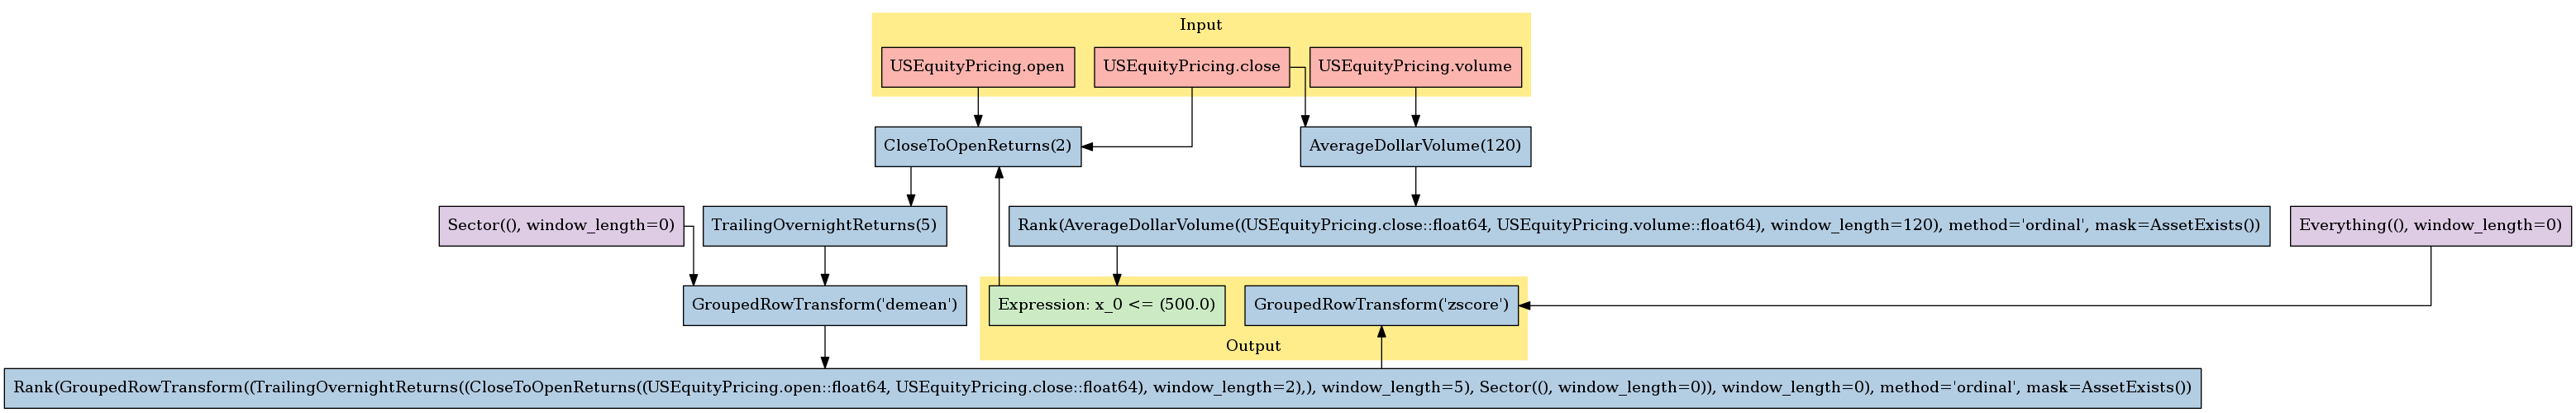

In [32]:
p.show_graph(format='png')

## run pipeline and view the factor data

In [33]:
df = engine.run_pipeline(p, factor_start_date, universe_end_date)

In [34]:
df.head()

Overnight_Sentiment
2014-01-03 00:00:00+00:00 Equity(0 [A])                0.000000
                          Equity(1 [AAL])             -1.662772
                          Equity(2 [AAP])             -1.064758
                          Equity(3 [AAPL])            -1.575258
                          Equity(4 [ABBV])            -0.787629

## Visualize factor returns

These are returns that a theoretical portfolio would have if its stock weights were determined by a single alpha factor's values.

In [35]:
from quiz_helper import make_factor_plot

Formatting factor data for: Overnight_Sentiment
Dropped 0.4% entries from factor data: 0.4% in forward returns computation and 0.0% in binning phase (set max_loss=0 to see potentially suppressed Exceptions).
max_loss is 35.0%, not exceeded: OK!
Time to get arrange factor data: 3.71 secs
Time to generate long/short returns: 0.39 secs


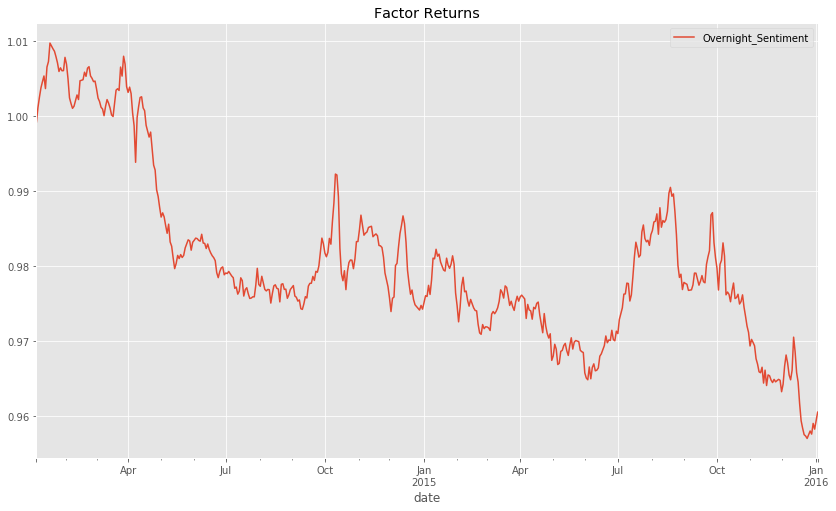

In [36]:
make_factor_plot(df, data_portal, trading_calendar, factor_start_date, universe_end_date);

## Solutions
Check out the [solution notebook here.](./overnight_returns_solution.ipynb)